# EKF Localization

In [103]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import matplotlib.pyplot as plt

# matplotlib.style.use('ggplot')
matplotlib.style.use('default')

In [104]:
from google.colab import drive
drive.mount("/content/drive/")
sys.path.append("/content/drive/My Drive/Colab Notebooks")
!ls "/content/drive/My Drive/Colab Notebooks"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
'Eymene Ouasime_Khiat_ekf_coursework.ipynb'


## Introduction

This coursework is about simulation of robot localization problem based on extended kalman filter (EKF).


In this simulation, the robot has a state vector which includes 4 states at time t,
$\textbf{x}_t=[x_t, y_t, \phi_t, v_t]$
where
$x_t$, $y_t$ are a 2D x-y position, $\phi_t$ is orientation (yaw angle), and $v_t$ is velocity. Covariace matrix of the state is given by $\textbf{P}_t$.  The initial state covariance matrix at time t = 0 can be given as

\begin{equation*} \mathbf P_0 = \begin{bmatrix} \sigma^2_{p_x} & 0 & 0 & 0 \\ 0 & \sigma^2_{p_y} & 0 & 0 \\ 0 & 0 & \sigma^2_{p_\phi} & 0 \\ 0 & 0 & 0 & \sigma^2_{p_v} \end{bmatrix} \end{equation*}

where $\sigma^2$ is a variance.



The robot has a Speed sensor and a Gyro sensor i.e. sensor fusion. So, the control input vector can be used at each
time step t,
$\textbf{u}_t=[v_t, \omega_t]$
where $v_t$ is velocity and $\omega_t$ (pronounced as omega_t) is angular velocity (yaw rate).

Also, the robot has a Global Navigation Satellite System (GNSS) sensor. This means that the robot can observe x-y
position at each time t.
$\textbf{z}_t=[x_t,y_t]$

The control input vector and observation vector include their corresponding sensor noise. Hence, we consider additive Gaussian noise.


## Process Model

We model the process or system as a non-linear robot motion model plus a noise.

$\textbf{x}_{t+1} = f(\textbf{x}_t, \textbf{u}_t) + w_x$

where $w_x$ is a zero-mean Gaussian white noise with covariance matrix $\textbf{Q}$ i.e. $w_x = \mathcal{N} (0, \textbf{Q})$. The process noise covariance matrix $\textbf{Q}$ can be given as

\begin{equation*} \mathbf Q = \begin{bmatrix} \sigma^2_{q_x} & 0 & 0 & 0 \\ 0 & \sigma^2_{q_y} & 0 & 0 \\ 0 & 0 & \sigma^2_{q_\phi} & 0 \\ 0 & 0 & 0 & \sigma^2_{q_v} \end{bmatrix} \end{equation*}


The non-linear robot motion function is given as

\begin{equation*} \begin{bmatrix} x' \\ y' \\ \phi' \\ v' \end{bmatrix} = f(\textbf{x}, \textbf{u}) = \begin{bmatrix} x + v\cos(\phi)\Delta t \\ y + v\sin(\phi)\Delta t \\ \phi + \omega \Delta t \\ v \end{bmatrix} \end{equation*}

$\Delta_t$ is a time interval. Note that $v$ is the velocity from the control input.


The Jacobian matrix of $f$ is


\begin{equation*} J_f = \frac{\partial f(\mathbf x, \mathbf u)}{\partial \mathbf x} = \begin{bmatrix} \frac{\partial f_1}{\partial x_1}& \frac{\partial f_1}{\partial x_2} & \frac{\partial f_1}{\partial x_3} & \frac{\partial f_1}{\partial x_4}\\ \frac{\partial f_2}{\partial x_1}& \frac{\partial f_2}{\partial x_2} & \frac{\partial f_2}{\partial x_3} & \frac{\partial f_2}{\partial x_4}\\ \frac{\partial f_3}{\partial x_1}& \frac{\partial f_3}{\partial x_2} & \frac{\partial f_3}{\partial x_3} & \frac{\partial f_3}{\partial x_4}\\ \frac{\partial f_4}{\partial x_1}& \frac{\partial f_4}{\partial x_2} & \frac{\partial f_4}{\partial x_3} & \frac{\partial f_4}{\partial x_4} \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} \frac{\partial x'}{\partial x}& \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{\partial v}\\ \frac{\partial \phi'}{\partial x}& \frac{\partial \phi'}{\partial y} & \frac{\partial \phi'}{\partial \phi} & \frac{\partial \phi'}{\partial v}\\ \frac{\partial v'}{\partial x}& \frac{\partial v'}{\partial y} & \frac{\partial v'}{\partial \phi} & \frac{\partial v'}{\partial v} \end{bmatrix} \end{equation*}


\begin{equation*} = \begin{bmatrix} 1& 0 & -v \sin(\phi) \Delta t & \cos(\phi) \Delta t\\ 0 & 1 & v \cos(\phi) \Delta t & \sin(\phi) \Delta t\\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \end{equation*}

<!-- \begin{equation*} = \begin{bmatrix} &  &  &  \\
                                    &  &  &  \\
                                    &  &  &  \\
                                    &  &  &  \end{bmatrix} \end{equation*} -->

\\

Note that the state transition matrix $\mathbf F$ is given as

$$
\begin{aligned}
\mathbf F
&= {\frac{\partial{f(\mathbf x, \mathbf u)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\end{aligned}
$$

## Observation Model

The robot can get x-y position infomation from GPS (GNSS).

So GPS or GNSS Observation model is given by

$\textbf{z}_{t} = h(\textbf{x}_t) + w_z$

where $w_z$ is a zero-mean Gaussian white noise with covariance matrix $\textbf{R}$ i.e. $w_z = \mathcal{N} (0, \textbf{R})$. The observation noise covariance matrix $\textbf{R}$ can be given as

\begin{equation*} \mathbf R = \begin{bmatrix} \sigma^2_{r_x} & 0  \\ 0 & \sigma^2_{r_y} \end{bmatrix} \end{equation*}


The observation function is given as

\begin{equation*} \begin{bmatrix} x' \\ y' \end{bmatrix} = h(\textbf{x}) = \begin{bmatrix} x \\ y \end{bmatrix} \end{equation*}

The Jacobian matrix of $h$ is

\begin{equation*} J_h =  \frac{\partial h(\mathbf x)}{\partial \mathbf x} = \begin{bmatrix} \frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} & \frac{\partial h_1}{\partial x_3} & \frac{\partial h_1}{\partial x_4}\\ \frac{\partial h_2}{\partial x_1}& \frac{\partial h_2}{\partial x_2} & \frac{\partial h_2}{\partial x_3} & \frac{\partial h_2}{ \partial x_4}\\ \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} \frac{\partial x'}{\partial x} & \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{ \partial v}\\ \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} 1& 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ \end{bmatrix} \end{equation*}

<!-- \begin{equation*} = \begin{bmatrix}   &  &   &  \\
                                      &  &   &  \\ \end{bmatrix} \end{equation*} -->


\\
Note that the measurement matrix $\mathbf H$ which maps the state space into the observation space is given as

$$
\begin{aligned}
\mathbf H &= \frac{\partial{h(\mathbf x})}{\partial{\mathbf x}}\biggr|_{\mathbf x_t}
\end{aligned}
$$


## EKF Algorithm

The EKF algorithm based on the above motion and observation functions can be summarized as follows:

$$\begin{array}{l|l}
\hline
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x, \mathbf u)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\text{Predict} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
 & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\mathbf x)}}{\partial{\mathbf x}}\biggr|_{\bar{\mathbf x}_t}} \\
\text{Update} & \mathbf{\bar{z}} = \boxed{h(\bar{\mathbf x})}\\
 & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
 & \mathbf x=\mathbf{\bar{x}} +\mathbf{K} (\mathbf{z} - \mathbf{\bar{z}}) \\
 & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} \\
 \hline
\end{array}$$

In this coursework, the following two pieces of code show a $\textbf{one line code}$ each equally since they are both numpy codes assigned to their corresponding single variable.

In [105]:
m = np.array([[3., 4.], [5., 6.]])
print(m)     # Is the same as
m = np.array([[3., 4],
              [5., 6]])
print(m)

[[3. 4.]
 [5. 6.]]
[[3. 4.]
 [5. 6.]]


PLease follow the $\textbf{instructions}$ given in the code. For instance, if the instruction says use one line of code, you $\textbf{MUST}$ use one line of code as your solution. You are also expected to comment your code properly where necessary. The equations of EKF given above needs to be used for its implementation in this coursework, which is a modification of the EKF given in the lecture slides (Lecture 8) considering additive process and observation noises.

You also need to fine-tune the necessary parameters for better as well as bad localization, such as $\textbf{Q}$, $\textbf{R}$, the noise ratio added to control input, and the noise ratio added to observation. You need to investigate under varying conditions: better and bad results, and why that happened. You need to support your results analysis using visualization. Analysis of correlation of states in a state vector using updated covariance from the last time step needs to be conducted as well.

In [106]:
# Simulation parameters
dt = 0.2  # delta_t, in second (s)
total_simulation_time = 65.0  # total simulation time, in second (s)

# Process noise covariance matrix
Q = np.diag([0.15, 0.15, np.deg2rad(1.0), 1.2]) ** 2

# Observation noise covariance matrix
R = np.diag([1.5, 1.5]) ** 2

In [107]:
def read_sensors(x_true, u):

    control_input_noise = np.diag([1.20, np.deg2rad(45.0)]) ** 2
    gps_noise = np.diag([1.0, 1.0]) ** 2

    x_true = motion_function_f(x_true, u)

    # Add noise to gps x-y position
    z = observation_function_h(x_true) + gps_noise @ np.random.randn(2, 1)

    # Add noise to control input
    u = u + control_input_noise @ np.random.randn(2, 1)

    return x_true, z, u


In [108]:
def motion_function_f(x, u):
    x = np.array([[x[0, 0] + u[0, 0] * math.cos(x[2, 0]) * dt],
                  [x[1, 0] + u[0, 0] * math.sin(x[2, 0]) * dt],
                  [x[2, 0] + u[1, 0] * dt],
                  [u[0, 0]]])  # Use ONE line of code, Fixed by enclosing all elements within a single list.
    return x

In [109]:
def observation_function_h(x):

    z = x[0: 2]  # Use ONE line of code.

    return z

In [110]:
def jacobian_f(x, u):
    """
    Jacobian of motion function f
    """
    Jf = np.array([[1, 0, -u[0, 0] * math.sin(x[2, 0]) * dt, math.cos(x[2, 0]) * dt ],
          [0, 1, u[0, 0] * math.cos(x[2, 0]) * dt, math.sin(x[2, 0]) * dt ],
          [0, 0, 1, 0],
          [0, 0, 0, 1]])  # Use ONE line of code.

    return Jf


In [111]:
def jacobian_h(x):
    """
    Jacobian of Observation function h.
    """
    Jh = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # Use ONE line of code.

    return Jh

In [112]:
def ekf(x_est, P_est, z, u):

    # Predict
    F = jacobian_f(x_est, u)  # Use ONE line of code.
    x_pred = motion_function_f(x_est, u)  # Use ONE line of code.
    P_pred = F @ P_est @ F.T + Q # Use ONE line of code.

    # Update
    H = jacobian_h(x_est)  # Use ONE line of code.
    z_pred = observation_function_h(x_pred)   # Use ONE line of code.
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R) # Use ONE line of code.
    x_est = x_pred + K @ (z - z_pred)  # Use ONE line of code.
    P_est = (np.identity(4) -( K @ H )) @ P_pred  # Use ONE line of code.
    return x_est, P_est

In [113]:
import matplotlib.pyplot as plt

def run_ekf():
    print("Simulation has started...")

    # Initialize state vector and covariance
    x_est = np.array([5.0, 5.0, 0.0, 0.0]).reshape(4, 1)  # Initial estimated state
    x_true = np.array([5.0, 5.0, 0.0, 0.0]).reshape(4, 1)  # Initial true state
    P_est = 1.15 * np.eye(4)  # Initial covariance matrix.

    # Pre-fill histories
    x_est_history = []  # Initial x_est_history as per your request
    x_true_history = []  # Based on initial x_true state
    z_history = []  # Assuming no initial measurement

    # Simulation loop
    for _ in np.arange(0, total_simulation_time, dt):
        # Control input (unchangeable!)
        u = np.array([[0.95], [-0.085]])  # v is in m/s and omega is grad/s.

        # Get sensor readings
        x_true, z, u = read_sensors(x_true, u)

        # Apply EKF
        x_est, P_est = ekf(x_est, P_est, z, u)

        # Append data to histories
        x_est_history.append([x_est[0, 0], x_est[1, 0]])  # Save only x and y
        x_true_history.append([x_true[0, 0], x_true[1, 0]])  # Save only x and y
        z_history.append([z[0, 0], z[1, 0]])  # Assuming z has x and y components



        # Todo: visualize true (ground-truth) trajectory, observation trajectory
        # and estimated trajectory in 2D xy-plane. You also need to visualize
        # estimated covariance ellipse at each current estimated state. Note
        # that you are free to add any number of lines of code in this function
        # (run_ekf) without changing the given ones.

    # Plot results
    plot_trajectories(x_true_history, x_est_history, z_history)

    # Print the histories for inspection
    print("x_est_history:", x_est_history)
    print("x_true_history:", x_true_history)
    print("z_history:", z_history)

    return x_est, P_est

        # Todo: visualize true (ground-truth) trajectory, observation trajectory
        # and estimated trajectory in 2D xy-plane. You also need to visualize
        # estimated covariance ellipse at each current estimated state. Note
        # that you are free to add any number of lines of code in this function
        # (run_ekf) without changing the given ones.


def plot_trajectories(x_true_history, x_est_history, z_history):
    """
    Plot the true and estimated trajectories in 2D.
    """
    x_true_history = np.array(x_true_history)  # Convert to NumPy array for plotting
    x_est_history = np.array(x_est_history)
    z_history = np.array(z_history)

    plt.plot(x_true_history[:, 0], x_true_history[:, 1], label="True Trajectory", color="blue")
    plt.plot(x_est_history[:, 0], x_est_history[:, 1], label="Estimated Trajectory", color="red", linestyle="--")
    plt.plot(z_history[:, 0], z_history[:, 1], label="Observation Trajectory", color="green", linestyle=":")
    plt.xlabel("X Position ")
    plt.ylabel("Y Position ")
    plt.title("True vs Estimated vs Observation Trajectories")
    plt.legend()
    plt.grid(True)
    plt.show()


Simulation has started...


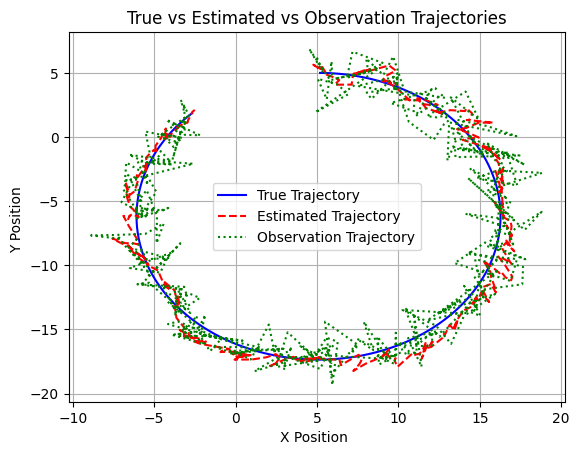

x_est_history: [[5.02518155962739, 5.408949170489221], [5.262964133635303, 5.3150408804555935], [4.775519932205582, 5.636543449178607], [5.1377618031775025, 5.333672479704094], [5.323941304334559, 5.461641166098068], [5.573911213026016, 4.945168378462311], [5.525342051765425, 4.883281262916415], [5.989141292175203, 4.676266727192152], [6.365414979564994, 4.435775636314013], [6.091284405867864, 4.081182287257414], [7.13827916156424, 4.083451799218249], [7.139453720621683, 4.183794022460038], [7.208963257721329, 4.803750143777982], [8.30671504382965, 5.304750770682016], [7.899200605477303, 5.128902533846177], [7.241969413739609, 4.922550539555242], [7.468415115977872, 4.992187374936005], [8.017926544999677, 5.256126635618949], [8.369808732182756, 5.20598962112791], [9.425192691457658, 5.579122261747986], [9.844681015759592, 5.176358040911817], [9.216714262677371, 4.7528190400775685], [8.986547650027024, 4.343691632935622], [9.492721553195178, 4.327525903174318], [9.359984765379679, 4.223

In [114]:
# Run the run_ekf() function
x_est, P_est = run_ekf()